# Contribution 2: Model Extension on the fail case

use data from usecase3 in contribution 1

model extension: create a human representation and llm representation. During testing, first turn test sentence to embedding, then the team has tested multiple similarity measure between test sentence embedding and human/gpt representation.

# Dependencies

In [1]:
%%capture
!pip install -U gdown
!pip install torch
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets
!pip install sentence_transformers

In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, RobertaModel
import torch
from torch.nn.functional import normalize, cosine_similarity
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer

# Data

## train

In [3]:
%%capture
# download data
!gdown 1AHlj3HRqv4DStCkVOk6OALp8JpRO_CZW

In [4]:
%%capture
# human train
data_source_1_human = pd.read_csv('contribution2_train_human_text.csv')[['text']]
data_source_1_human['label'] = 0

# llm train
data_source_1_llm = pd.DataFrame(
    load_dataset('jjz5463/llm-detection-generation-contribution2-train',
                 split='train')
    )[['generations by the LLM.']]
data_source_1_llm.rename(columns={'generations by the LLM.': 'text'}, inplace=True)
data_source_1_llm['label'] = 1

# training data, use human data from usecase 2
ctr3_train_data = pd.concat([data_source_1_human, data_source_1_llm])

In [5]:
print(f'Train data shape is {ctr3_train_data.shape}')

Train data shape is (4842, 2)


## test

In [6]:
%%capture
# llm test
u3_llm_test = pd.DataFrame(
    load_dataset('jjz5463/llm-detection-generation-failcase-test',
                 split='train')
    )[['generations by the LLM.']]
u3_llm_test.rename(columns={'generations by the LLM.': 'text'}, inplace=True)
u3_llm_test['label'] = 1

# human test
data_source_2_human = pd.DataFrame(
    load_dataset('ChristophSchuhmann/essays-with-instructions',
                 split='train')
    )[['essays']]
data_source_2_human.rename(columns={'essays': 'text'}, inplace=True)
data_source_2_human['label'] = 0

# testing data
ctr3_test_data = pd.concat([data_source_2_human, u3_llm_test])

# split dev from test
ctr3_dev_data, ctr3_test_data = train_test_split(ctr3_test_data, test_size=0.9, stratify=ctr3_test_data['label'], random_state=42)

In [7]:
print(f'Test data shape is {ctr3_test_data.shape}')

Test data shape is (3716, 2)


In [8]:
# dev data
print(f'Dev data shape is {ctr3_dev_data.shape}')

Dev data shape is (412, 2)


# Embedding

## human and llm representation

In [9]:
%%capture
# train, we are using the genreated sentence in the train to produce GPT represetnation
gpt_sentences_u3 = list(ctr3_train_data[ctr3_train_data['label']==1]['text'])

wegmann = SentenceTransformer('AnnaWegmann/Style-Embedding')#efederici/sentence-bert-base
usecase3_train_gpt_wegmann_embeddings = wegmann.encode(gpt_sentences_u3)
gpt_representation3_wegmann = usecase3_train_gpt_wegmann_embeddings.mean(axis=0)

In [10]:
# train, we are using the genreated sentence in the train to produce GPT represetnation
human_sentences_u3 = list(ctr3_train_data[ctr3_train_data['label']==0]['text'])

wegmann = SentenceTransformer('AnnaWegmann/Style-Embedding')
usecase3_train_human_wegmann_embeddings = wegmann.encode(human_sentences_u3)
human_representation3_wegmann = usecase3_train_human_wegmann_embeddings.mean(axis=0)

## embeddings of dev and test

In [11]:
dev_sentences_u3 = list(ctr3_dev_data['text'])
usecase3_dev_wegmann_embeddings = wegmann.encode(dev_sentences_u3)

In [12]:
test_sentences_u3 = list(ctr3_test_data['text'])
usecase3_test_wegmann_embeddings = wegmann.encode(test_sentences_u3)

# Methods

We tested multiple methods that measures similarity

In [13]:
#@title archive method, concatenate -> FFNN
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
# import numpy as np
# import pandas as pd

# X = np.array([np.concatenate([emb, gpt_representation3_wegmann, human_representation3_wegmann]) for emb in train2_wegmann_embeddings])
# y = np.array(list(train2_data['label']))

# # Converting arrays to PyTorch tensors
# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32)

# # Creating DataLoader for training and testing
# train_dataset = TensorDataset(X, y)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# import torch.nn as nn
# import torch.nn.functional as F

# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(gpt_representation3_wegmann.shape[0]*2, 2048)
#         self.fc2 = nn.Linear(2048, 512)
#         self.fc5 = nn.Linear(512, 1)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc5(x))
#         return x

# model = MLP()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCELoss()

# # Training loop
# def train_model(model, train_loader):
#     model.train()
#     for epoch in range(10):  # Example: 10 epochs
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs.squeeze(), labels)
#             loss.backward()
#             optimizer.step()
#             print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# train_model(model, train_loader)

# def predict(model, data):
#     model.eval()
#     with torch.no_grad():
#         outputs = model(data)
#         # Apply threshold
#         #predicted_labels = (outputs.squeeze() < 0.999).float()
#         return outputs#predicted_labels

# # Example new data prediction

# test_data_full = [np.concatenate([emb - gpt_representation3_wegmann, human_representation3_wegmann]) for emb in usecase3_test_wegmann_embeddings]
# new_data = torch.tensor(test_data_full, dtype=torch.float32)
# predictions = predict(model, new_data)

# labels = ctr3_test_data['label']
# # Define the color palette for the labels
# palette = {0: 'blue', 1: 'green'}  # Blue for label 0, Green for label 1
# # Plotting
# sns.histplot(x=predictions.squeeze().numpy(), hue=labels,
#              element='step', stat='density', common_norm=False, bins=100, palette=palette)
# threshold1 = 0.5
# plt.axvline(x=threshold1, color='red', linestyle='--', label='Classification Threshold')
# plt.title('Distribution of prob')
# plt.xlabel('prob')
# plt.ylabel('Density')

# # Manually adding legend entries
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=palette[0], label='Label 0'),
#                    Patch(facecolor=palette[1], label='Label 1'),
#                    Patch(facecolor='red', label='Classification Threshold', linestyle='--')]
# plt.legend(handles=legend_elements, title='Legend')

# plt.show()

# # Calculate metrics
# accuracy = accuracy_score(ctr3_test_data['label'], predictions)
# precision, recall, f1, _ = precision_recall_fscore_support(ctr3_test_data['label'], predictions, average='binary')

# # Confusion matrix
# conf_matrix = confusion_matrix(ctr3_test_data['label'], predictions)
# sns.heatmap(conf_matrix, annot=True, fmt='d')
# plt.title('Confusion Matrix (Usecase 3 - wegmann)')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

# # Output metrics
# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'F1 Score: {f1}')

## Method 1: cosine similarity

### choose a threshold on dev

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity to GPT and human representations
similarity_to_gpt = cosine_similarity(usecase3_dev_wegmann_embeddings, gpt_representation3_wegmann[np.newaxis, :])
similarity_to_human = cosine_similarity(usecase3_dev_wegmann_embeddings, human_representation3_wegmann[np.newaxis, :])

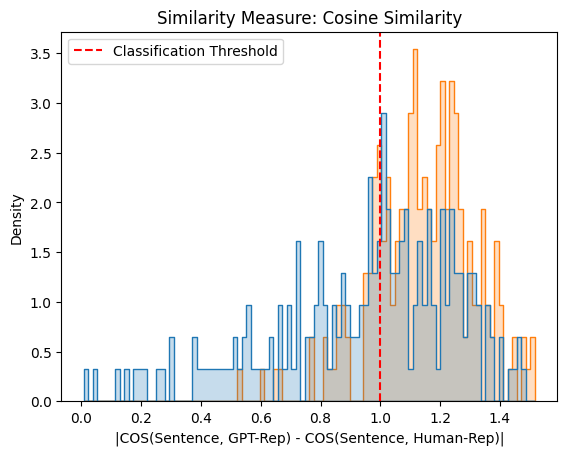

In [15]:
cos_threshold = 1

sns.histplot(x=abs(similarity_to_gpt - similarity_to_human).reshape(-1,),
             hue=ctr3_dev_data['label'], element='step', stat='density',
             common_norm=False, bins=100)
plt.axvline(x=cos_threshold, color='red', linestyle='--', label='Classification Threshold')
plt.title('Similarity Measure: Cosine Similarity')
plt.xlabel('|COS(Sentence, GPT-Rep) - COS(Sentence, Human-Rep)|')
plt.ylabel('Density')
plt.legend()
plt.show()

In [16]:
# Initialize predictions array
predictions_cos = []

# Classify based on higher similarity
for gpt_sim, human_sim in zip(similarity_to_gpt, similarity_to_human):
    if abs(gpt_sim - human_sim)>cos_threshold:
        predictions_cos.append(1)
    else:
        predictions_cos.append(0)

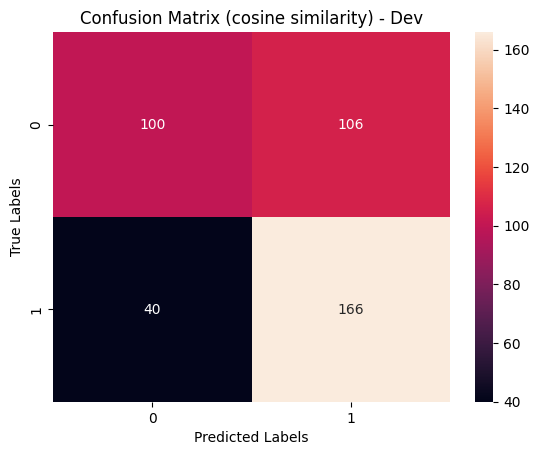

Accuracy: 0.6456310679611651
Precision: 0.6102941176470589
Recall: 0.8058252427184466
F1 Score: 0.6945606694560669


In [17]:
# Calculate metrics
accuracy = accuracy_score(ctr3_dev_data['label'], predictions_cos)
precision, recall, f1, _ = precision_recall_fscore_support(ctr3_dev_data['label'], predictions_cos, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_dev_data['label'], predictions_cos)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (cosine similarity) - Dev')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### run on test

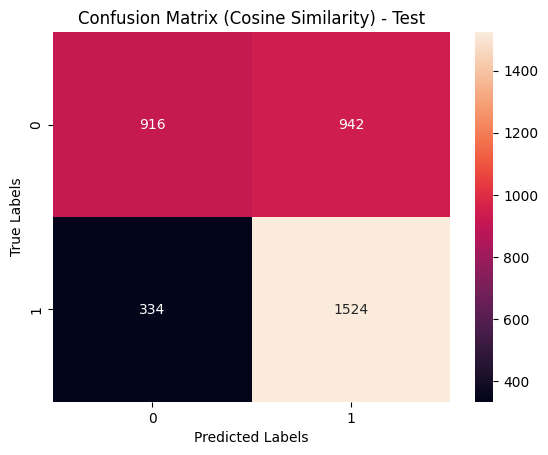

Accuracy: 0.6566200215285253
Precision: 0.6180048661800487
Recall: 0.8202368137782562
F1 Score: 0.7049028677150787


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity to GPT and human representations
similarity_to_gpt = cosine_similarity(usecase3_test_wegmann_embeddings, gpt_representation3_wegmann[np.newaxis, :])
similarity_to_human = cosine_similarity(usecase3_test_wegmann_embeddings, human_representation3_wegmann[np.newaxis, :])

# Initialize predictions array
predictions = []

# Classify based on higher similarity
for gpt_sim, human_sim in zip(similarity_to_gpt, similarity_to_human):
    if abs(gpt_sim - human_sim)>cos_threshold:
        predictions.append(1)
    else:
        predictions.append(0)

# Calculate metrics
accuracy_1 = accuracy_score(ctr3_test_data['label'], predictions)
precision_1, recall_1, f1_1, _ = precision_recall_fscore_support(ctr3_test_data['label'], predictions, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_test_data['label'], predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Cosine Similarity) - Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision_1}')
print(f'Recall: {recall_1}')
print(f'F1 Score: {f1_1}')

## Method 2: euclidean distance

### choose a threshold on dev

In [19]:
from sklearn.metrics.pairwise import euclidean_distances

# Calculate Euclidean distances to GPT and human representations
distance_to_gpt = euclidean_distances(usecase3_dev_wegmann_embeddings, gpt_representation3_wegmann[np.newaxis, :])
distance_to_human = euclidean_distances(usecase3_dev_wegmann_embeddings, human_representation3_wegmann[np.newaxis, :])

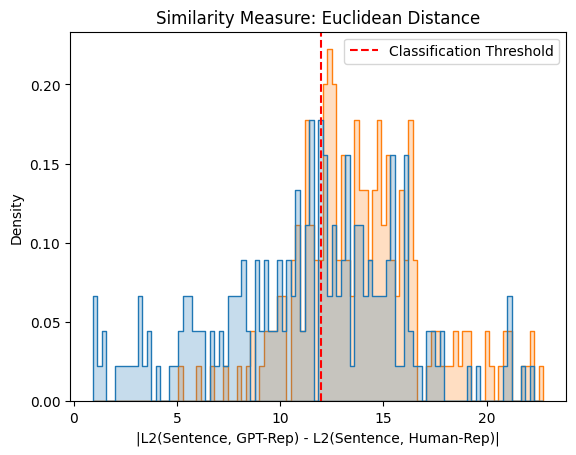

In [20]:
euc_threshold = 12

sns.histplot(x=abs(distance_to_gpt - distance_to_human).reshape(-1,),
             hue=ctr3_dev_data['label'], element='step', stat='density',
             common_norm=False, bins=100)
plt.axvline(x=euc_threshold, color='red', linestyle='--', label='Classification Threshold')
plt.title('Similarity Measure: Euclidean Distance')
plt.xlabel('|L2(Sentence, GPT-Rep) - L2(Sentence, Human-Rep)|')
plt.ylabel('Density')
plt.legend()
plt.show()

In [21]:
# Initialize predictions array
predictions_euc = []

# Classify based on shorter distance
for gpt_dist, human_dist in zip(distance_to_gpt, distance_to_human):
    if abs(gpt_dist - human_dist)>euc_threshold:
        predictions_euc.append(1)
    else:
        predictions_euc.append(0)

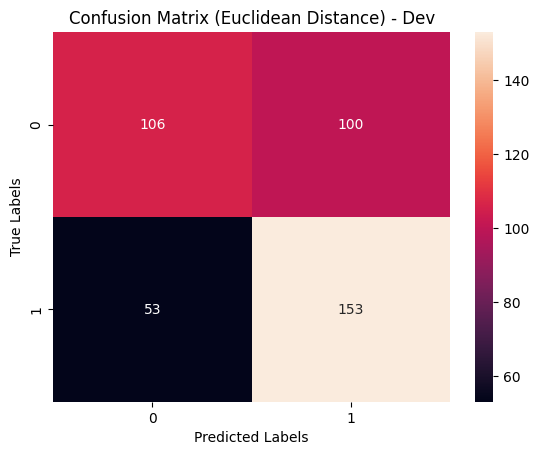

Accuracy: 0.6286407766990292
Precision: 0.6047430830039525
Recall: 0.7427184466019418
F1 Score: 0.6666666666666666


In [22]:
# Calculate metrics
accuracy = accuracy_score(ctr3_dev_data['label'], predictions_euc)
precision, recall, f1, _ = precision_recall_fscore_support(ctr3_dev_data['label'], predictions_euc, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_dev_data['label'], predictions_euc)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Euclidean Distance) - Dev')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### run on test

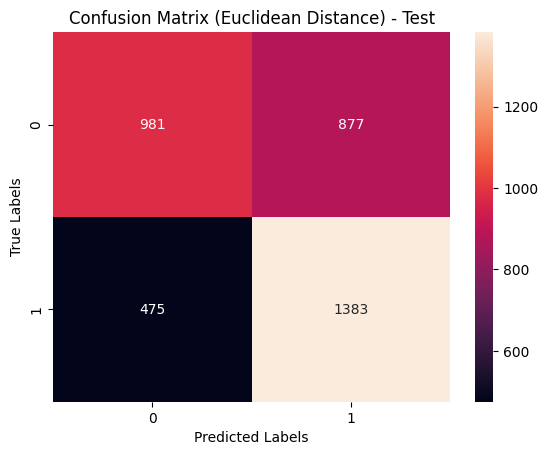

Accuracy: 0.6361679224973089
Precision: 0.6119469026548673
Recall: 0.7443487621097955
F1 Score: 0.6716852841185043


In [23]:
from sklearn.metrics.pairwise import euclidean_distances

# Calculate Euclidean distances to GPT and human representations
distance_to_gpt = euclidean_distances(usecase3_test_wegmann_embeddings, gpt_representation3_wegmann[np.newaxis, :])
distance_to_human = euclidean_distances(usecase3_test_wegmann_embeddings, human_representation3_wegmann[np.newaxis, :])

# Initialize predictions array
predictions = []

# Classify based on shorter distance
for gpt_dist, human_dist in zip(distance_to_gpt, distance_to_human):
    if abs(gpt_dist - human_dist)>euc_threshold:
        predictions.append(1)
    else:
        predictions.append(0)

# Calculate metrics
accuracy_2 = accuracy_score(ctr3_test_data['label'], predictions)
precision_2, recall_2, f1_2, _ = precision_recall_fscore_support(ctr3_test_data['label'], predictions, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_test_data['label'], predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Euclidean Distance) - Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision_2}')
print(f'Recall: {recall_2}')
print(f'F1 Score: {f1_2}')

## Method 3: dot product

### choose a threshold on dev

In [24]:
import numpy as np

# Calculate dot products
dot_product_to_gpt = np.dot(usecase3_dev_wegmann_embeddings, gpt_representation3_wegmann)
dot_product_to_human = np.dot(usecase3_dev_wegmann_embeddings, human_representation3_wegmann)

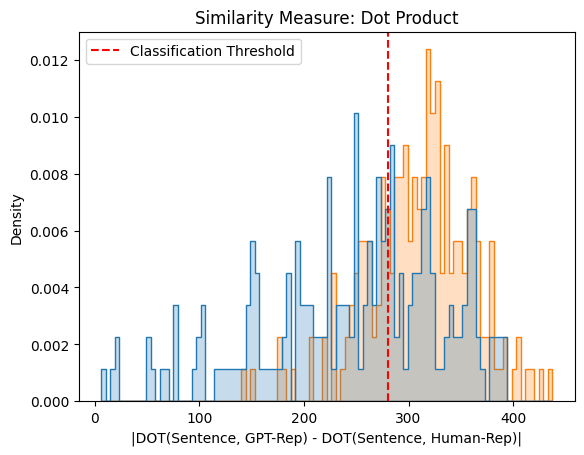

In [25]:
dot_threshold = 280

sns.histplot(x=abs(dot_product_to_gpt - dot_product_to_human),
             hue=ctr3_dev_data['label'], element='step', stat='density',
             common_norm=False, bins=100)
plt.axvline(x=dot_threshold, color='red', linestyle='--', label='Classification Threshold')
plt.title('Similarity Measure: Dot Product')
plt.xlabel('|DOT(Sentence, GPT-Rep) - DOT(Sentence, Human-Rep)|')
plt.ylabel('Density')
plt.legend()
plt.show()


In [26]:
# Initialize predictions array
predictions = []

# Classify based on higher dot product
for gpt_dot, human_dot in zip(dot_product_to_gpt, dot_product_to_human):
    if abs(gpt_dot - human_dot) > dot_threshold:
        predictions.append(1)
    else:
        predictions.append(0)

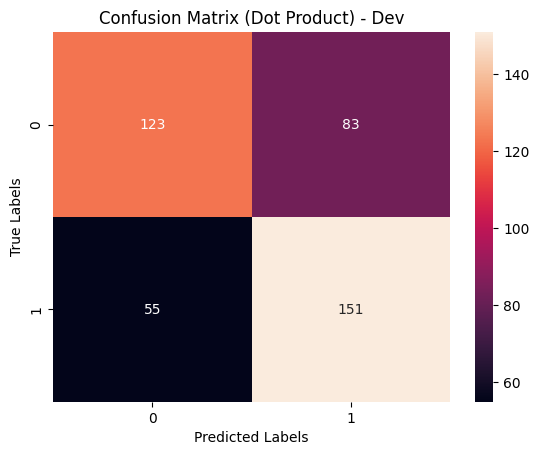

Accuracy: 0.6650485436893204
Precision: 0.6452991452991453
Recall: 0.7330097087378641
F1 Score: 0.6863636363636364


In [27]:
# Calculate metrics
accuracy = accuracy_score(ctr3_dev_data['label'], predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ctr3_dev_data['label'], predictions, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_dev_data['label'], predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Dot Product) - Dev')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### run on test

In [28]:
dot_product_gpt_test = np.dot(usecase3_test_wegmann_embeddings, gpt_representation3_wegmann)
dot_product_human_test = np.dot(usecase3_test_wegmann_embeddings, human_representation3_wegmann)

In [29]:
predictions_test = []
for gpt_dot, human_dot in zip(dot_product_gpt_test, dot_product_human_test):
    if abs(gpt_dot - human_dot) > dot_threshold:
        predictions_test.append(1)
    else:
        predictions_test.append(0)

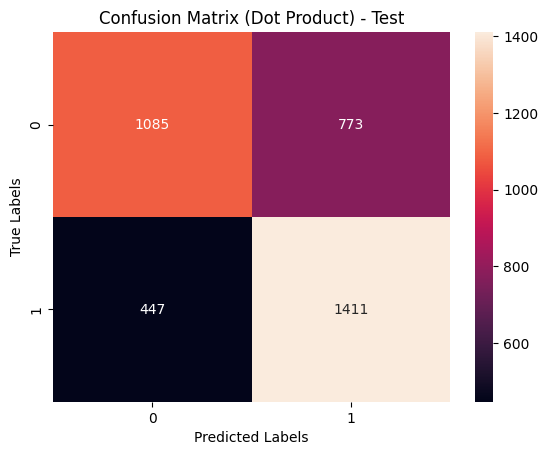

Accuracy: 0.6716899892357373
Precision: 0.6460622710622711
Recall: 0.7594187298170075
F1 Score: 0.698169223156853


In [30]:
# Calculate metrics
accuracy_3 = accuracy_score(ctr3_test_data['label'], predictions_test)
precision_3, recall_3, f1_3, _ = precision_recall_fscore_support(ctr3_test_data['label'], predictions_test, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_test_data['label'], predictions_test)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (Dot Product) - Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision_3}')
print(f'Recall: {recall_3}')
print(f'F1 Score: {f1_3}')

## Method 4: pca &  eculidean distance

### choose a threshold on dev

<ipython-input-31-57db5fd6e063>:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(transformed_human[:, 0], transformed_human[:, 1], color='blue', edgecolors='black', s=200, marker='x', label='Human')


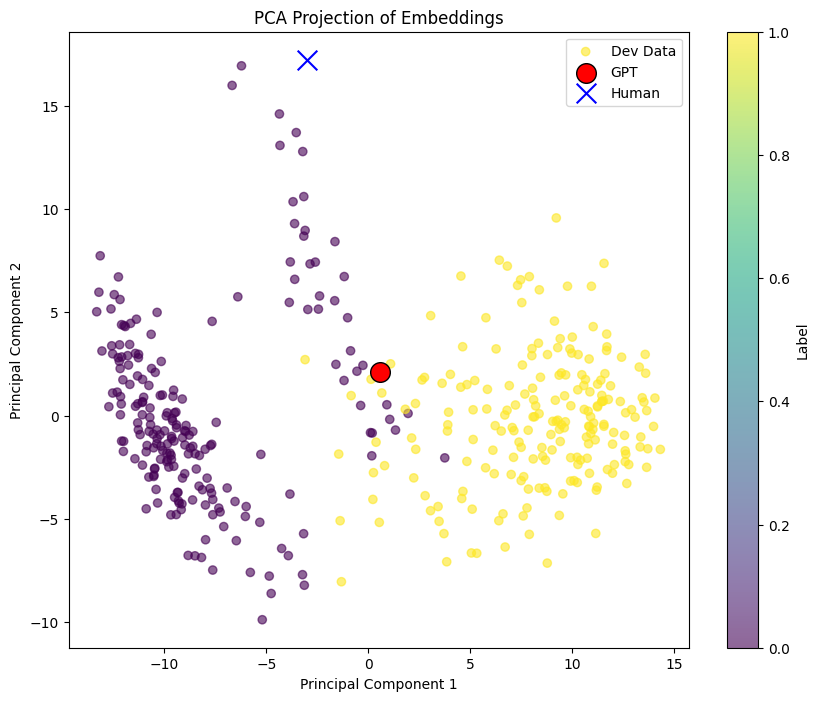

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

labels = ctr3_dev_data['label']

# Initialize PCA and reduce dimensions
pca = PCA(n_components=2)
pca.fit(usecase3_dev_wegmann_embeddings)

# Transform the main embeddings and the GPT/Human embeddings
transformed_main_embeddings = pca.transform(usecase3_dev_wegmann_embeddings)
transformed_gpt = pca.transform(gpt_representation3_wegmann[np.newaxis, :])
transformed_human = pca.transform(human_representation3_wegmann[np.newaxis, :])

# Plotting
plt.figure(figsize=(10, 8))

# Scatter plot for the main embeddings
scatter = plt.scatter(transformed_main_embeddings[:, 0], transformed_main_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Dev Data')
plt.colorbar(scatter, label='Label')

# Plot GPT and Human points
plt.scatter(transformed_gpt[:, 0], transformed_gpt[:, 1], color='red', edgecolors='black', s=200, marker='o', label='GPT')
plt.scatter(transformed_human[:, 0], transformed_human[:, 1], color='blue', edgecolors='black', s=200, marker='x', label='Human')

# Adding labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Embeddings')
plt.legend(loc='best')

# Display the plot
plt.show()


In [32]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

# Calculate Euclidean distances to reduced GPT and human representations
distance_to_gpt = euclidean_distances(transformed_main_embeddings, transformed_gpt)
distance_to_human = euclidean_distances(transformed_main_embeddings, transformed_human)

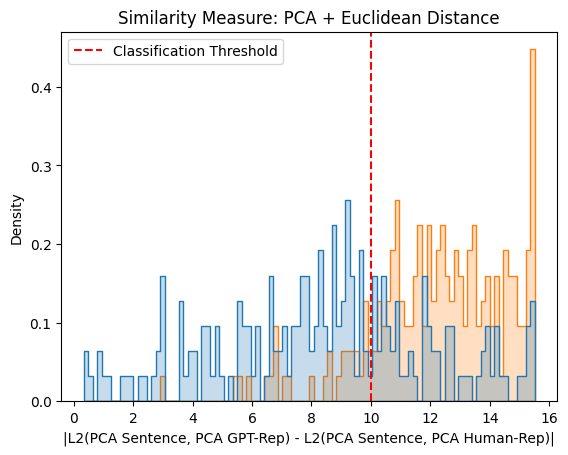

In [33]:
pca_threshold = 10

sns.histplot(x=abs(distance_to_gpt - distance_to_human).reshape(-1,),
             hue=ctr3_dev_data['label'], element='step', stat='density',
             common_norm=False, bins=100)
plt.axvline(x=pca_threshold, color='red', linestyle='--', label='Classification Threshold')
plt.title('Similarity Measure: PCA + Euclidean Distance')
plt.xlabel('|L2(PCA Sentence, PCA GPT-Rep) - L2(PCA Sentence, PCA Human-Rep)|')
plt.ylabel('Density')
plt.legend()
plt.show()

In [34]:
# Initialize predictions array
predictions_pca = []

# Classify based on shorter distance
for gpt_dist, human_dist in zip(distance_to_gpt, distance_to_human):
    if abs(gpt_dist - human_dist) > pca_threshold:
        predictions_pca.append(1)
    else:
        predictions_pca.append(0)

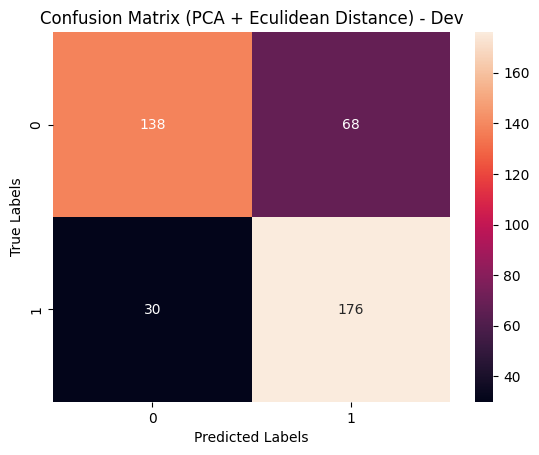

Accuracy: 0.7621359223300971
Precision: 0.7213114754098361
Recall: 0.8543689320388349
F1 Score: 0.7822222222222223


In [35]:
# Calculate metrics
accuracy = accuracy_score(ctr3_dev_data['label'], predictions_pca)
precision, recall, f1, _ = precision_recall_fscore_support(ctr3_dev_data['label'], predictions_pca, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_dev_data['label'], predictions_pca)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (PCA + Eculidean Distance) - Dev')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

### run on test

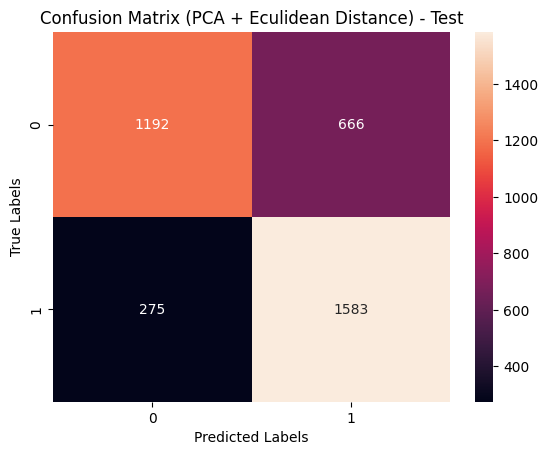

Accuracy: 0.7467707212055974
Precision: 0.7038683859493108
Recall: 0.8519913885898815
F1 Score: 0.7708789870952034


In [36]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

reduced_test_embeddings = pca.transform(usecase3_test_wegmann_embeddings)

# Calculate Euclidean distances to reduced GPT and human representations
distance_to_gpt = euclidean_distances(reduced_test_embeddings, transformed_gpt)
distance_to_human = euclidean_distances(reduced_test_embeddings, transformed_human)

# Initialize predictions array
predictions = []

# Classify based on shorter distance
for gpt_dist, human_dist in zip(distance_to_gpt, distance_to_human):
    if abs(gpt_dist - human_dist) > pca_threshold:
        predictions.append(1)
    else:
        predictions.append(0)

# Calculate metrics
accuracy_4 = accuracy_score(ctr3_test_data['label'], predictions)
precision_4, recall_4, f1_4, _ = precision_recall_fscore_support(ctr3_test_data['label'], predictions, average='binary')

# Confusion matrix
conf_matrix = confusion_matrix(ctr3_test_data['label'], predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix (PCA + Eculidean Distance) - Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Output metrics
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision_4}')
print(f'Recall: {recall_4}')
print(f'F1 Score: {f1_4}')


# table

In [37]:
table = pd.DataFrame({
    "Accuracy": [accuracy_1, accuracy_2, accuracy_3, accuracy_4],
    "Precision": [precision_1, precision_2, precision_3, precision_4],
    "Recall": [recall_1, recall_2, recall_3, recall_4],
    "F1 Score": [f1_1, f1_2, f1_3, f1_4]
}, index=["Method 1: Cosine Similarity",
          "Method 2: Euclidean Distance",
          "Method 3: Dot Product",
          "Method 4: PCA -> Eculidean Distance"])

table

,Accuracy,Precision,Recall,F1 Score
Method 1: Cosine Similarity,0.656620,0.618005,0.820237,0.704903
Method 2: Euclidean Distance,0.636168,0.611947,0.744349,0.671685
Method 3: Dot Product,0.671690,0.646062,0.759419,0.698169
Method 4: PCA -> Eculidean Distance,0.746771,0.703868,0.851991,0.770879
